# LSTM Forecasting of Earthquake Magnitude

https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

In [1]:
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
from data.data import EarthquakeData
from earthquakes.settings import read_coordinates

cwd = Path.home() / "earthquakes"
load_dotenv(cwd / ".env")
(minlat, maxlat), (minlong, maxlong) = read_coordinates()
# data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
qdata = EarthquakeData(
    pd.read_csv(Path.home() / "earthquakes/csv/9923ce9a42736848b544e335a4d7c5fb.csv"),
    numeric_columns=["latitude", "longitude", "depth", "mag"],
    zero_columns=["depth", "mag"],
    target="mag",
    drop_time_column=True,
    min_latitude=minlat,
    min_longitude=minlong,
    # min_magnitude=4,
    scaler_mode='minmax',
)
data = qdata.process()

In [2]:
data.describe()

,latitude,longitude,depth,mag
count,4860.000000,4860.000000,4860.000000,4860.000000
mean,0.588975,0.603332,0.202339,0.555073
std,0.211186,0.316424,0.149638,0.079996
min,0.000071,0.000063,0.000000,0.243590
25%,0.457850,0.331777,0.075601,0.525641
50%,0.691726,0.583354,0.147881,0.564103
75%,0.707752,0.927962,0.361856,0.602564
max,1.000000,1.000000,1.000000,1.000000


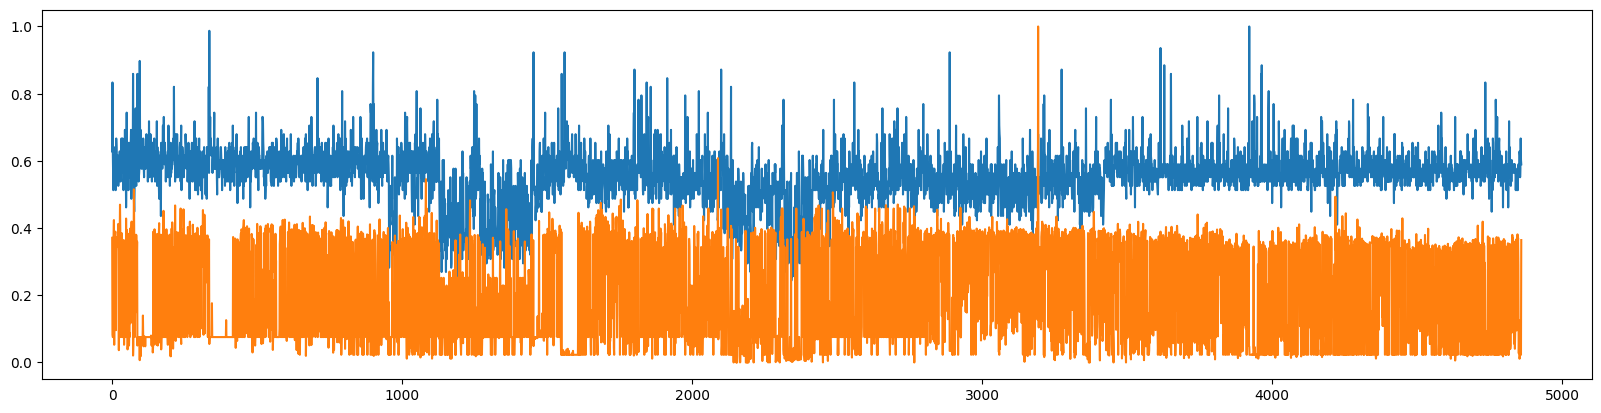

In [3]:
import matplotlib.pyplot as plt
timeseries = data[["mag","depth"]].astype('float32')
 
plt.plot(timeseries)
plt.gcf().set_figwidth(20)
plt.show()

In [6]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
type(train), type(test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [9]:
import torch
import numpy as np

def create_dataset(dataset: pd.DataFrame, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target[[qdata.target]])
        
    X,y = np.vstack(X), np.vstack(y)
    return torch.tensor(X), torch.tensor(y)

lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([3255, 2]) torch.Size([3255, 1])
torch.Size([1603, 2]) torch.Size([1603, 1])


In [14]:
import torch.nn as nn

class ForecastModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=50, num_layers=10, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [11]:
torch.cuda.is_available()

True

In [15]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = ForecastModel().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
train_dataset = data.TensorDataset(X_train, y_train)
test_dataset = data.TensorDataset(X_test, y_test)
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=8)
test_loader = data.DataLoader(test_dataset, shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue

    model.eval()
    with torch.no_grad():
        original, forecast = [], []
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch.to(device)).detach().cpu()
            original.append(y_batch)
            forecast.append(y_pred)

        original = torch.cat(original, dim=0)
        forecast = torch.cat(forecast, dim=0)
        train_rmse = np.sqrt(loss_fn(original, forecast))

        original, forecast = [], []
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch.to(device)).detach().cpu()
            original.append(y_batch)
            forecast.append(y_pred)

        original = torch.cat(original, dim=0)
        forecast = torch.cat(forecast, dim=0)
        test_rmse = np.sqrt(loss_fn(original, forecast))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.0917, test RMSE 0.0538
Epoch 100: train RMSE 0.0769, test RMSE 0.0591
Epoch 200: train RMSE 0.0760, test RMSE 0.0547
Epoch 300: train RMSE 0.0765, test RMSE 0.0541
Epoch 400: train RMSE 0.0764, test RMSE 0.0540
Epoch 500: train RMSE 0.0761, test RMSE 0.0545
Epoch 600: train RMSE 0.0755, test RMSE 0.0550
Epoch 700: train RMSE 0.0753, test RMSE 0.0557
Epoch 800: train RMSE 0.0753, test RMSE 0.0563
Epoch 900: train RMSE 0.0753, test RMSE 0.0544
Epoch 1000: train RMSE 0.0756, test RMSE 0.0587
Epoch 1100: train RMSE 0.0754, test RMSE 0.0547
Epoch 1200: train RMSE 0.0752, test RMSE 0.0562
Epoch 1300: train RMSE 0.0755, test RMSE 0.0576
Epoch 1400: train RMSE 0.0749, test RMSE 0.0564
Epoch 1500: train RMSE 0.0754, test RMSE 0.0588
Epoch 1600: train RMSE 0.0749, test RMSE 0.0564
Epoch 1700: train RMSE 0.0748, test RMSE 0.0560
Epoch 1800: train RMSE 0.0748, test RMSE 0.0558
Epoch 1900: train RMSE 0.0744, test RMSE 0.0557


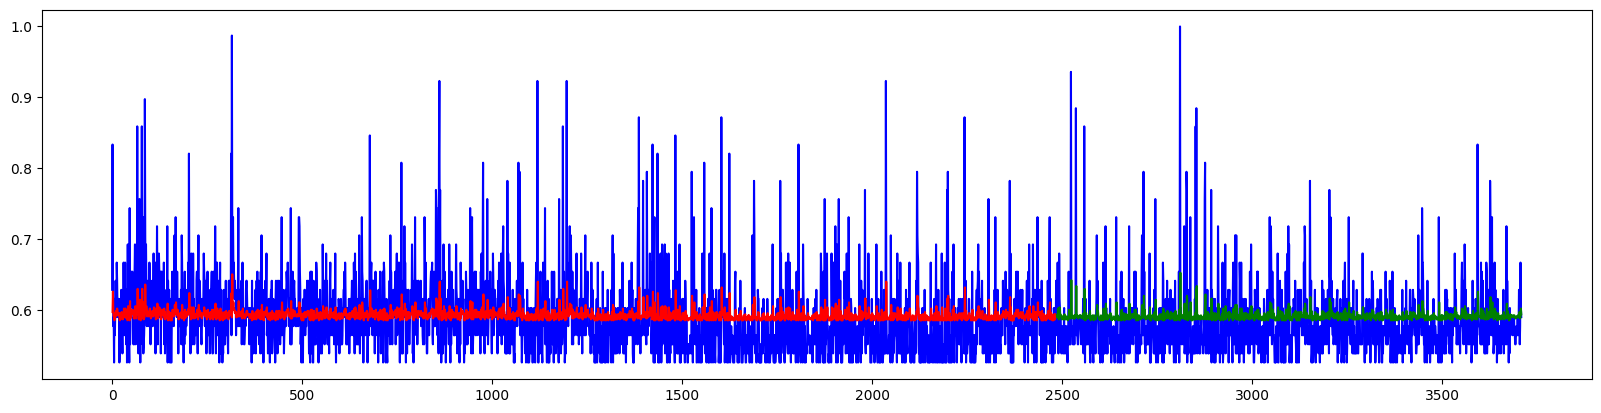

In [11]:
model.eval()
train_plot = np.ones_like(timeseries) * np.nan
test_plot = np.ones_like(timeseries) * np.nan
with torch.no_grad():
    # shift train predictions for plotting
    train_input = torch.Tensor(X_train).to(device)
    y_pred = model(train_input).detach().cpu()
    train_plot[lookback:train_size] = y_pred[:, -1, :]
    # shift test predictions for plotting
    test_input = torch.Tensor(X_test).to(device)
    test_output = torch.Tensor(y_test).to(device)
    y_pred = model(test_input).detach().cpu()
    test_plot[train_size+lookback:len(timeseries)] = y_pred[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')


In [ ]:
plt.plot(test_plot, c='g')
plt.gcf().set_figwidth(20)
plt.show()